# 第3週：傲慢與偏見情緒分析
**Author:** 黃天原<br>
**Date created:** 2021/09/30<br>
**Last modified:** 2021/09/30<br>
本週課程為「情緒分析1」，目的為了解lexicon-base 情緒分析。情緒分析步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、lexicon-base 情緒分析

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量長條圖
    + 3.4 正負向情緒分數比例折線圖
    + 3.5 文字雲
      + 第18章文字雲
    + 3.6 情緒代表字
      + ch.18 正負相情緒代表字

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- re: 正規表達式套件。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。

In [4]:
# 安裝會使用到的套件
# %pip install wordcloud

In [5]:
# 確認當前工作目錄
%pwd

'/home/evan19983314/SMA/SMA_2023S/week4_sentiment_analysis'

In [6]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download("punkt") # 下載需要用到的語料庫
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 150

[nltk_data] Downloading package punkt to
[nltk_data]     /home/evan19983314/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2. 資料前處理
基本上在前一次上課的內容已經提過，本節課直接沿用前一次課程清理完成的文集結果。

## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC情緒字典與清理完成的傲慢與偏見
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
- 分為正向情緒與負向情緒

In [7]:
# 讀取情緒字典
def load_sentiment_dict(en_dict_pos_path, en_dict_neg_path):
    
    with open(en_dict_pos_path) as f:
        pos_word = [line.strip() for line in f.readlines()]
        pos_label = ["positive" for i in range(len(pos_word))]

    with open(en_dict_neg_path) as f:
        neg_word = [line.strip() for line in f.readlines()]
        neg_label = ["negative" for i in range(len(neg_word))]
        
    words = pos_word + neg_word
    labels = pos_label + neg_label
    sentiment_dict = pd.DataFrame({"word" : words, "sentiments" : labels})
    return sentiment_dict

liwc_dict = load_sentiment_dict(en_dict_pos_path="./dict/liwc/en/positive.txt", en_dict_neg_path="./dict/liwc/en/negative.txt")
liwc_dict

,word,sentiments
0,abound,positive
1,abounds,positive
2,abundance,positive
3,abundant,positive
4,accessable,positive
...,...,...
6781,zaps,negative
6782,zealot,negative
6783,zealous,negative
6784,zealously,negative


在前一次上課的文字處理，會把傲慢與偏見的英文處理好，因此請讀入前次的 `csv` 檔案

In [8]:
path = "../week3_nlp/raw_data/clean_en_data.csv" # 你可以換成自己的傲慢與偏見位置，理論上是這個
book_df = pd.read_csv(path, index_col=False)
book_df

,sentence,chapter,token,word,lemma_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudice
2,It is a truth universally acknowledged that a ...,1,truth,truth,truth
3,It is a truth universally acknowledged that a ...,1,universally,universally,universally
4,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledged
...,...,...,...,...,...
52253,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person
52254,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bringing
52255,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshire
52256,Darcy as well as Elizabeth really loved them a...,61,means,means,mean


### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

In [9]:
book_liwc_df = pd.merge(book_df, liwc_dict, how = 'left')
book_liwc_df

,sentence,chapter,token,word,lemma_token,sentiments
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,NaN
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudice,negative
2,It is a truth universally acknowledged that a ...,1,truth,truth,truth,NaN
3,It is a truth universally acknowledged that a ...,1,universally,universally,universally,NaN
4,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledged,NaN
...,...,...,...,...,...,...
52253,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person,NaN
52254,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bringing,NaN
52255,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshire,NaN
52256,Darcy as well as Elizabeth really loved them a...,61,means,means,mean,NaN


In [10]:
# 算出每章情緒總和(sentiment_count)

sentiment_count = pd.DataFrame(book_liwc_df.groupby(['chapter', 'sentiments']).size()).reset_index()
print(sentiment_count)

sentiment_count = sentiment_count.rename(columns={0: 'size'})
sentiment_count

     chapter sentiments    0
0          0   negative    1
1          1   negative   22
2          1   positive   33
3          2   negative   20
4          2   positive   22
..       ...        ...  ...
118       59   positive  117
119       60   negative   44
120       60   positive   91
121       61   negative   42
122       61   positive   66

[123 rows x 3 columns]


,chapter,sentiments,size
0,0,negative,1
1,1,negative,22
2,1,positive,33
3,2,negative,20
4,2,positive,22
...,...,...,...
118,59,positive,117
119,60,negative,44
120,60,positive,91
121,61,negative,42


### 3.3 正負向情緒分數聲量長條
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [11]:
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']
pos

,chapter,sentiments,size
2,1,positive,33
4,2,positive,22
6,3,positive,82
8,4,positive,73
10,5,positive,48
...,...,...,...
114,57,positive,48
116,58,positive,96
118,59,positive,117
120,60,positive,91


In [12]:
neg

,chapter,sentiments,size
0,0,negative,1
1,1,negative,22
3,2,negative,20
5,3,negative,42
7,4,negative,28
...,...,...,...
113,57,negative,54
115,58,negative,92
117,59,negative,74
119,60,negative,44


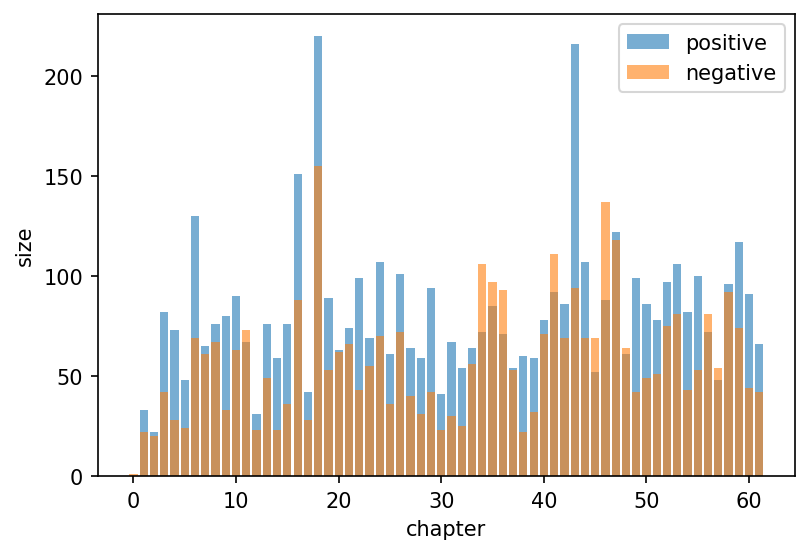

In [13]:
# you can find other color pattern here: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ["tab:blue",  "tab:orange"]
fig, ax = plt.subplots()

ax.bar(pos['chapter'],
       pos['size'],
       color = colors[0],
       alpha = 0.6,
       align='center')
ax.bar(neg['chapter'],
       neg['size'], 
       color = colors[1],
       alpha = 0.6,
       align='center')
plt.xlabel('chapter')
plt.ylabel('size')

ax.legend(['positive','negative'], loc ='upper right') 
plt.show()

In [14]:
pos.loc[pos['chapter'].isin(range(15,25))]

,chapter,sentiments,size
30,15,positive,76
32,16,positive,151
34,17,positive,42
36,18,positive,220
38,19,positive,89
40,20,positive,63
42,21,positive,74
44,22,positive,99
46,23,positive,69
48,24,positive,107


In [15]:
pos.loc[pos['chapter'].isin(range(40,45))]

,chapter,sentiments,size
80,40,positive,78
82,41,positive,92
84,42,positive,86
86,43,positive,216
88,44,positive,107


畫出每章的情緒總分數，可以看到正向情緒在 18 與 43 章較高

### 3.4 正負向情緒分數比例折線圖圖

In [16]:
sentiment_count

,chapter,sentiments,size
0,0,negative,1
1,1,negative,22
2,1,positive,33
3,2,negative,20
4,2,positive,22
...,...,...,...
118,59,positive,117
119,60,negative,44
120,60,positive,91
121,61,negative,42


In [17]:
sentiment_count.groupby('chapter')['size'].transform(lambda n : n/n.sum())

0      1.000000
1      0.400000
2      0.600000
3      0.476190
4      0.523810
         ...   
118    0.612565
119    0.325926
120    0.674074
121    0.388889
122    0.611111
Name: size, Length: 123, dtype: float64

In [18]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("chapter")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,chapter,sentiments,size,ratio
0,0,negative,1,1.000000
1,1,negative,22,0.400000
2,1,positive,33,0.600000
3,2,negative,20,0.476190
4,2,positive,22,0.523810
...,...,...,...,...
118,59,positive,117,0.612565
119,60,negative,44,0.325926
120,60,positive,91,0.674074
121,61,negative,42,0.388889


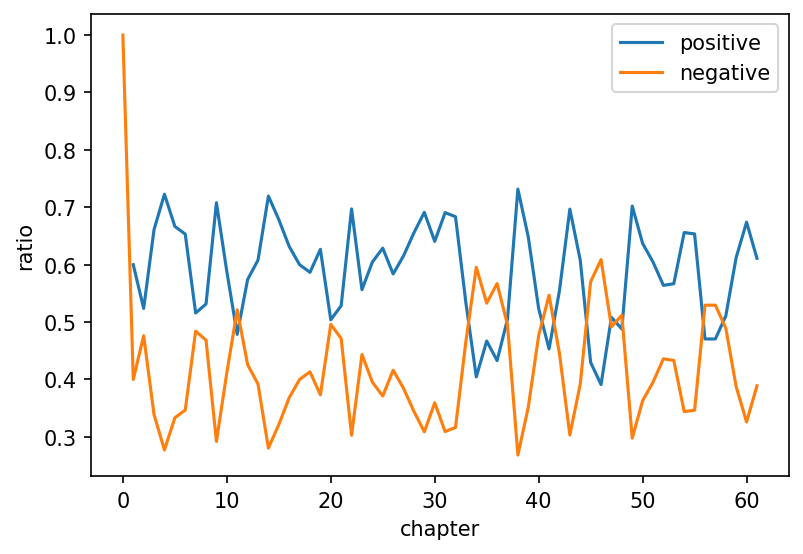

In [19]:
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']
fig, ax = plt.subplots()

ax.plot(pos['chapter'],
       pos['ratio'],
       color = colors[0])
ax.plot(neg['chapter'],
       neg['ratio'], 
       color = colors[1])
plt.xlabel('chapter')
plt.ylabel('ratio')

ax.legend(['positive','negative'], loc ='upper right') 

### 3.5 文字雲
針對不同章節畫出該章的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [20]:
# 先看看正面詞出現最多的章節
sentiment_count.sort_values("size", ascending=False)

,chapter,sentiments,size,ratio
36,18,positive,220,0.586667
86,43,positive,216,0.696774
35,18,negative,155,0.413333
32,16,positive,151,0.631799
91,46,negative,137,0.608889
...,...,...,...,...
75,38,negative,22,0.268293
1,1,negative,22,0.400000
4,2,positive,22,0.523810
3,2,negative,20,0.476190


#### 第 18 章


In [21]:
book_liwc_df.head()

,sentence,chapter,token,word,lemma_token,sentiments
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,NaN
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudice,negative
2,It is a truth universally acknowledged that a ...,1,truth,truth,truth,NaN
3,It is a truth universally acknowledged that a ...,1,universally,universally,universally,NaN
4,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledged,NaN


In [22]:
## 篩選出 18 章且正向情緒的詞彙
mask = (book_liwc_df['chapter']==18) & (book_liwc_df['sentiments']=='positive')
book_tf_by_ch_df = book_liwc_df.loc[mask]
book_tf_by_ch_df

,sentence,chapter,token,word,lemma_token,sentiments
11825,She had dressed with more than usual care and ...,18,trusting,trusting,trusting,positive
11836,But in an instant arose the dreadful suspicion...,18,pleasure,pleasure,pleasure,positive
11850,But in an instant arose the dreadful suspicion...,18,eagerly,eagerly,eagerly,positive
11862,But in an instant arose the dreadful suspicion...,18,significant,significant,significant,positive
11863,But in an instant arose the dreadful suspicion...,18,smile,smile,smile,positive
...,...,...,...,...,...,...
14008,Mrs_Bennet was perfectly satisfied and quitted...,18,delightful,delightful,delightful,positive
14037,Of having another daughter married to Mr_Colli...,18,pleasure,pleasure,pleasure,positive
14046,Elizabeth was the least dear to her of all her...,18,good,good,good,positive
14047,Elizabeth was the least dear to her of all her...,18,enough,enough,enough,positive


In [23]:
wc_18 = book_tf_by_ch_df.groupby(['word']).size().to_dict()
wc_18

{'advantage': 2,
 'advantages': 1,
 'affection': 1,
 'affirmative': 1,
 'agreeable': 3,
 'amaze': 1,
 'amazed': 1,
 'amazement': 1,
 'appeal': 1,
 'assurances': 1,
 'assure': 4,
 'assuring': 1,
 'astonishment': 1,
 'attentive': 1,
 'audible': 1,
 'beneficial': 1,
 'better': 1,
 'bright': 1,
 'capable': 2,
 'charming': 1,
 'civility': 4,
 'clever': 1,
 'comfort': 2,
 'comfortable': 1,
 'compatible': 1,
 'compliment': 3,
 'conciliatory': 1,
 'confidence': 2,
 'congratulations': 1,
 'delicate': 1,
 'delight': 1,
 'delighted': 2,
 'delightful': 2,
 'desirable': 1,
 'desirous': 1,
 'dignity': 2,
 'eagerly': 2,
 'elegance': 1,
 'enjoying': 1,
 'enough': 4,
 'exceedingly': 1,
 'excellent': 1,
 'exultation': 1,
 'fair': 1,
 'faithful': 1,
 'fancy': 1,
 'favour': 2,
 'felicity': 2,
 'finer': 1,
 'fond': 1,
 'fortunate': 3,
 'free': 1,
 'freedom': 1,
 'glad': 1,
 'glow': 1,
 'good': 4,
 'grateful': 1,
 'gratified': 1,
 'gratifying': 2,
 'great': 3,
 'greatest': 2,
 'handsome': 1,
 'happiness': 1

In [24]:
len(wc_18)

133

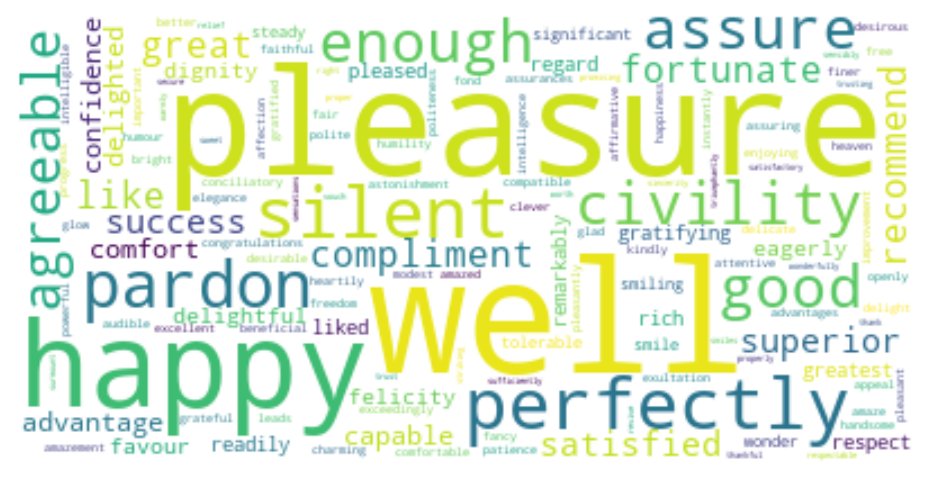

In [25]:
## wordcloud 的 input 是一個 dict, key是 word, value 是次數
# wc_18['assure']
cloud = WordCloud(max_words=200, background_color="white")
cloud.generate_from_frequencies(wc_18)
# 繪圖
# plt.figure(figsize=(10,5), dpi=300)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [26]:
word_count = book_liwc_df.groupby(['word', 'sentiments']).size().reset_index()
word_count.columns = ['word', 'sentiments','size']
word_count.sort_values("size", ascending=False)

,word,sentiments,size
851,miss,negative,281
1379,well,positive,211
564,good,positive,191
583,great,positive,142
435,enough,positive,103
...,...,...,...
1035,recommendations,positive,1
666,impolitic,negative,1
297,deservedly,positive,1
1032,rebuke,negative,1


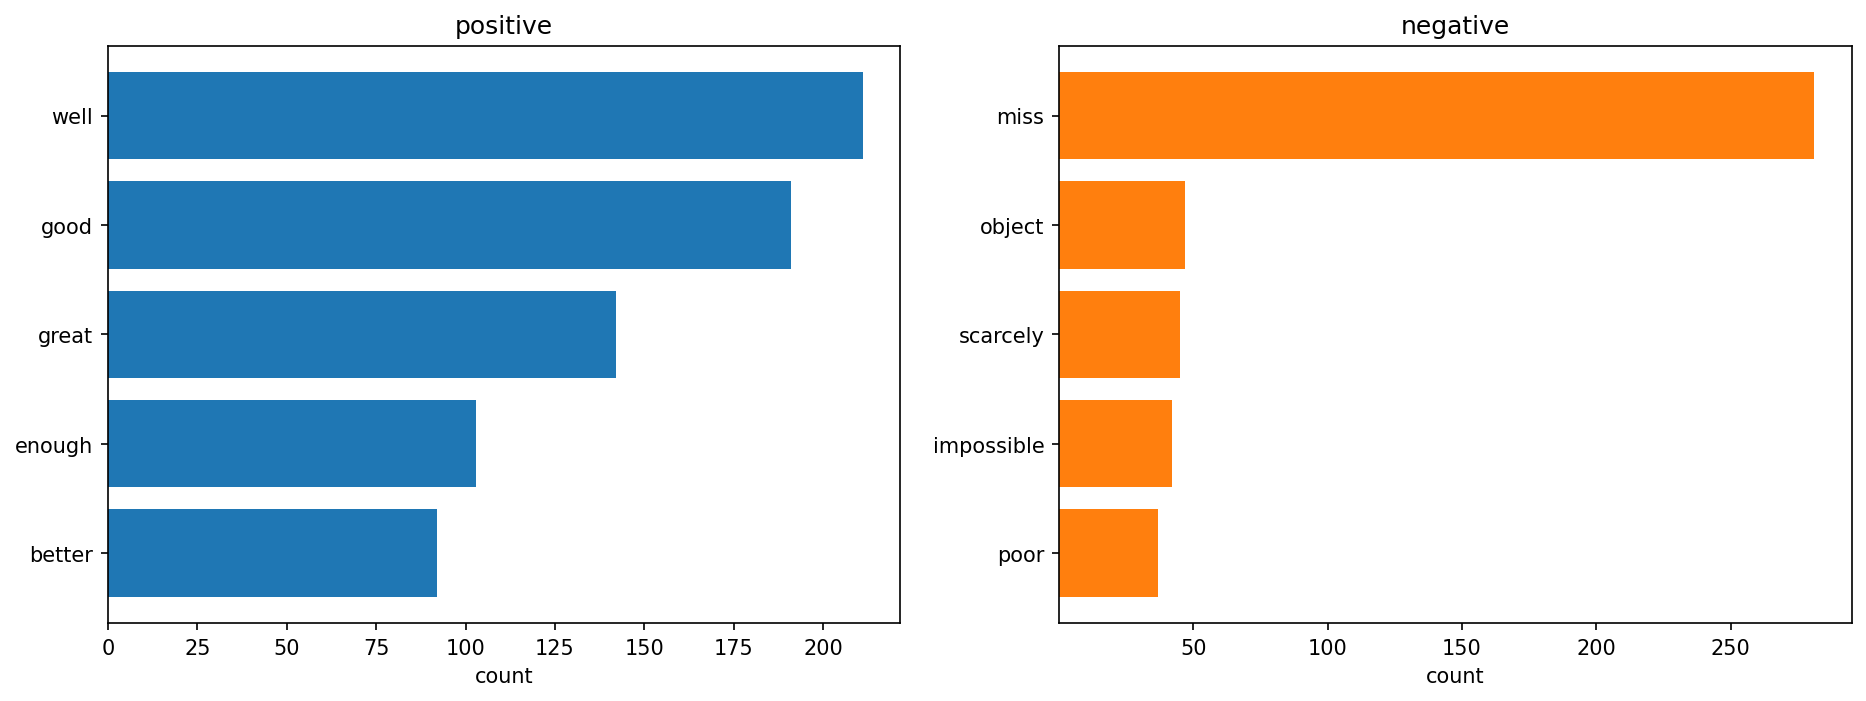

In [27]:
pos = word_count[word_count['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-5:]
neg = word_count[word_count['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-5:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[0].set_title("positive")

ax[1].xaxis.set_ticks([25,50,75,100,125,150,175]) 
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')
ax[1].set_title("negative")
ax[1].xaxis.set_ticks([50,100,150,200,250])

另外，也可以依據不同章節觀察情緒代表字的變化
#### ch.18 正負向情緒代表字

In [28]:
mask = (book_liwc_df['chapter']==18) & (~book_liwc_df['sentiments'].isna())
word_count_ch18 = book_liwc_df.loc[mask, ['word','sentiments']]
word_count_ch18 = word_count_ch18.groupby(['word', 'sentiments']).size().reset_index(name='size')
word_count_ch18.sort_values('size',ascending=False)

,word,sentiments,size
146,miss,negative,11
240,well,positive,8
168,pleasure,positive,7
163,perfectly,positive,6
200,silent,positive,6
...,...,...,...
99,grateful,positive,1
100,gratified,positive,1
102,gravely,negative,1
106,handsome,positive,1


Text(0.5, 0, 'count')

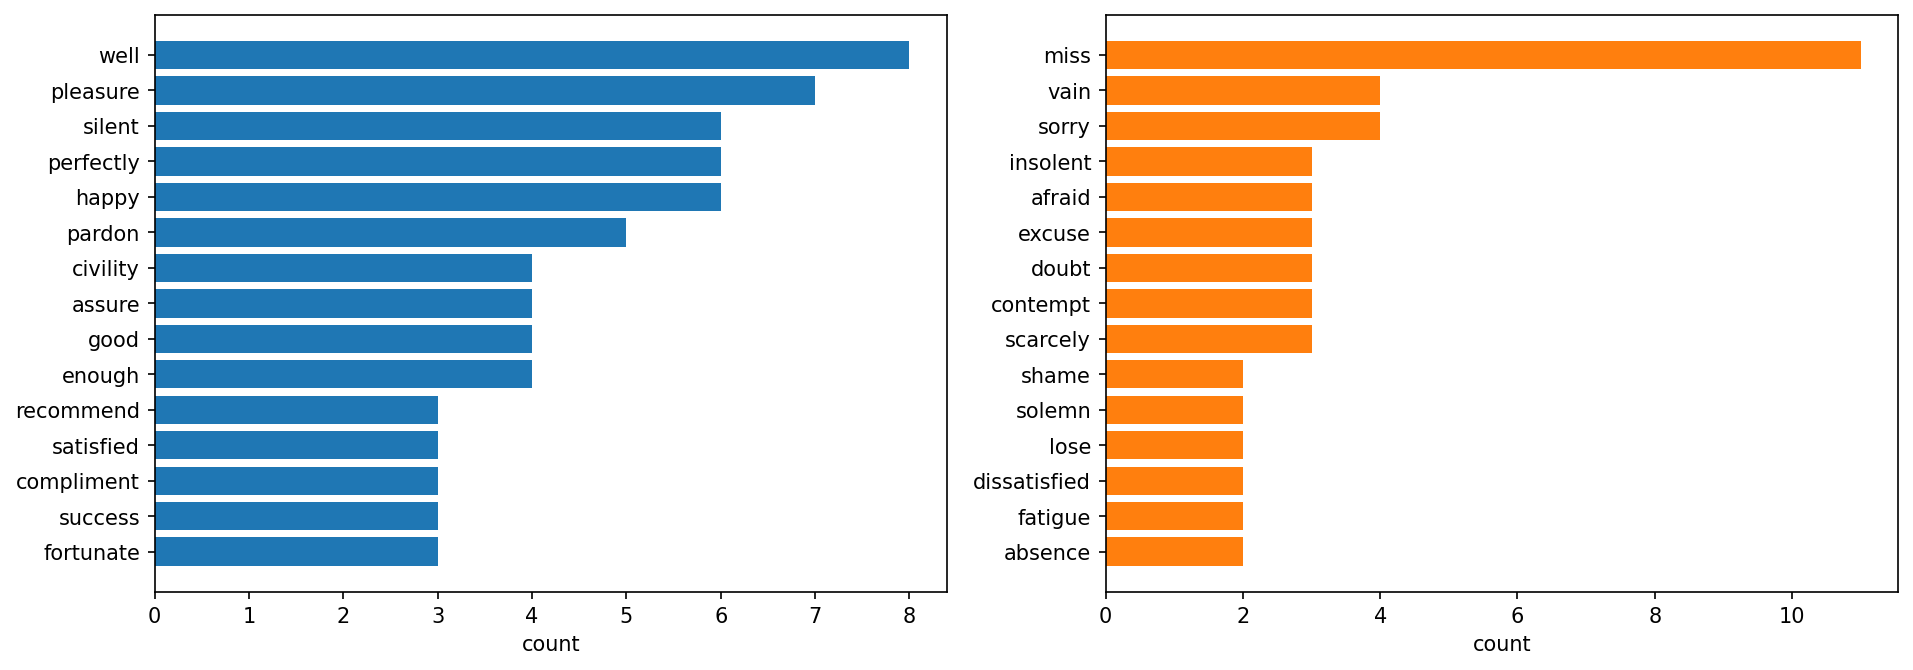

In [29]:
pos = word_count_ch18[word_count_ch18['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-15:]
neg = word_count_ch18[word_count_ch18['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-15:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')

## 3.7 各章情緒分數

In [105]:
sentiment_count

,chapter,sentiments,size,ratio
0,0,negative,1,1.000000
1,1,negative,22,0.400000
2,1,positive,33,0.600000
3,2,negative,20,0.476190
4,2,positive,22,0.523810
...,...,...,...,...
118,59,positive,117,0.612565
119,60,negative,44,0.325926
120,60,positive,91,0.674074
121,61,negative,42,0.388889


In [106]:
mask = ~book_liwc_df['sentiments'].isna()
book_sentiment_value = sentiment_count.pivot_table(index='chapter', columns='sentiments', values='size', fill_value=0).reset_index().rename_axis(None, axis=1)
book_sentiment_value.head()

,chapter,negative,positive
0,0,1,0
1,1,22,33
2,2,20,22
3,3,42,82
4,4,28,73


In [107]:
book_sentiment_value['sentiment_value'] = book_sentiment_value['positive'] - book_sentiment_value['negative']
book_sentiment_value.head()

,chapter,negative,positive,sentiment_value
0,0,1,0,-1
1,1,22,33,11
2,2,20,22,2
3,3,42,82,40
4,4,28,73,45


Text(0, 0.5, 'sentiment value')

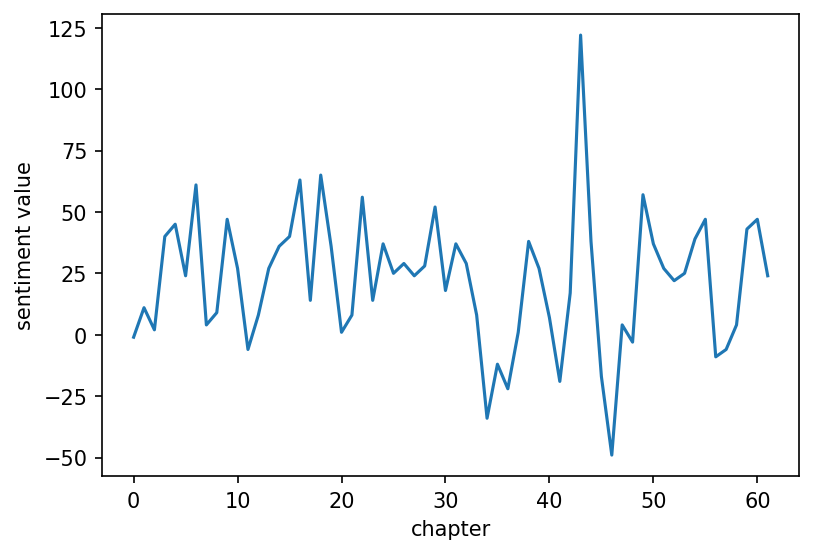

In [112]:
fig, ax = plt.subplots()
ax.plot(book_sentiment_value['chapter'], book_sentiment_value["sentiment_value"])
ax.set_xlabel('chapter')
ax.set_ylabel('sentiment value')